In [ ]:
import pandas as pd
import numpy as np
import re
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, BertTokenizerFast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
from torch.utils.data import DataLoader, TensorDataset, RandomSampler
from torch.optim import AdamW # Import AdamW from torch.optim

In [ ]:
# Mount Google Drive (upload train.csv first)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load data
df = pd.read_csv('/content/drive/MyDrive/Uni Master/AML/train.csv')
print(df.head())

       textID                                               text  \
0  28ac06f416                        good luck with your auction   
1  92098cf9a7  Hmm..You can`t judge a book by looking at its ...   
2  7858ff28f2   Hello, yourself. Enjoy London. Watch out for ...   
3  b0c9c67f32         We can`t even call you from belgium  sucks   
4  7b36e9e7a5                                 not so good mood..   

                                       selected_text sentiment  
0                        good luck with your auction  positive  
1  Hmm..You can`t judge a book by looking at its ...   neutral  
2                                    They`re mental.  negative  
3                                            m  suck  negative  
4                                 not so good mood..  negative  


In [ ]:
def clean_tweet(tweet):
    # Remove URLs, user mentions, and non-alphanumeric characters (keep emoticons)
    tweet = re.sub(r"http\S+|www\S+|@\w+", '', tweet)  # Remove URLs/mentions
    tweet = re.sub(r'[^\w\s!?.,:;)(\-]', '', tweet)    # Keep emoticons (e.g., ":)", "-(")
    return tweet.strip()

# Apply cleaning
df['cleaned_text'] = df['text'].apply(clean_tweet)

In [ ]:
# Split data: 70% train, 15% validation, 15% test
train, temp = train_test_split(df, test_size=0.3, random_state=42)
valid, test = train_test_split(temp, test_size=0.5, random_state=42)
# Encode labels (negative:0, neutral:1, positive:2)
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
train['label'] = train['sentiment'].map(label_map)
valid['label'] = valid['sentiment'].map(label_map)
test['label'] = test['sentiment'].map(label_map)
print(f"Train: {len(train)}, Valid: {len(valid)}, Test: {len(test)}")

Train: 17312, Valid: 3710, Test: 3710


# BERT

In [ ]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

def encode_texts(texts, max_len=64):
    input_ids = []
    attention_masks = []
    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return torch.tensor(input_ids), torch.tensor(attention_masks)

# Tokenize datasets
train_ids, train_masks = encode_texts(train['cleaned_text'].tolist())
valid_ids, valid_masks = encode_texts(valid['cleaned_text'].tolist())
test_ids, test_masks = encode_texts(test['cleaned_text'].tolist())

# Convert to PyTorch datasets
train_data = TensorDataset(train_ids, train_masks, torch.tensor(train['label'].values))
valid_data = TensorDataset(valid_ids, valid_masks, torch.tensor(valid['label'].values))
test_data = TensorDataset(test_ids, test_masks, torch.tensor(test['label'].values))

# Data loaders
batch_size = 64
train_loader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=batch_size)
valid_loader = DataLoader(valid_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
model_bert = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3,  # 3 classes
    output_attentions=False,
    output_hidden_states=False
)

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_bert.to(device)

# Optimizer
optimizer = AdamW(model_bert.parameters(), lr=2e-5, eps=1e-8)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from tqdm.auto import tqdm  # For progress bar

epochs = 3
for epoch in range(epochs):
    model_bert.train()

    # Initialize progress bar for training
    train_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]", leave=False)

    for batch in train_progress:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
        outputs = model_bert(**inputs)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Update progress bar description with current loss
        train_progress.set_postfix({'loss': loss.item()})

    # Validation
    model_bert.eval()
    val_preds, val_true = [], []

    # Initialize progress bar for validation
    val_progress = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]", leave=False)

    for batch in val_progress:
        batch = tuple(t.to(device) for t in batch)
        with torch.no_grad():
            outputs = model_bert(batch[0], attention_mask=batch[1])
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        val_preds.extend(preds)
        val_true.extend(batch[2].cpu().numpy())

    # Compute validation F1 score
    val_f1 = f1_score(val_true, val_preds, average='macro')
    print(f"\nEpoch {epoch+1} | Validation F1: {val_f1:.3f}")

Epoch 1/3 [Training]:   0%|          | 0/271 [00:00<?, ?it/s]

Epoch 1/3 [Validation]:   0%|          | 0/58 [00:00<?, ?it/s]


Epoch 1 | Validation F1: 0.794


Epoch 2/3 [Training]:   0%|          | 0/271 [00:00<?, ?it/s]

Epoch 2/3 [Validation]:   0%|          | 0/58 [00:00<?, ?it/s]


Epoch 2 | Validation F1: 0.788


Epoch 3/3 [Training]:   0%|          | 0/271 [00:00<?, ?it/s]

Epoch 3/3 [Validation]:   0%|          | 0/58 [00:00<?, ?it/s]


Epoch 3 | Validation F1: 0.779


In [ ]:
import time
start_time = time.time()
model_bert.eval()
test_preds, test_true = [], []
for batch in test_loader:
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
        outputs = model_bert(batch[0], attention_mask=batch[1])
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1).cpu().numpy()
    test_preds.extend(preds)
    test_true.extend(batch[2].cpu().numpy())

print("Test Report:")
print(classification_report(test_true, test_preds, target_names=label_map.keys()))
end_time = time.time()

inference_time = end_time - start_time
print(f"Inference time: {inference_time:.4f} seconds")

Test Report:
              precision    recall  f1-score   support

    negative       0.79      0.78      0.78      1038
     neutral       0.75      0.72      0.74      1512
    positive       0.79      0.84      0.81      1160

    accuracy                           0.78      3710
   macro avg       0.78      0.78      0.78      3710
weighted avg       0.77      0.78      0.77      3710

Inference time: 11.8732 seconds


# TF-IDF

In [ ]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))  # Use unigrams + bigrams

# Fit on training data
X_train = tfidf.fit_transform(train['cleaned_text'])
y_train = train['sentiment']

# Transform validation/test
X_val = tfidf.transform(valid['cleaned_text'])
y_val = valid['sentiment']
X_test = tfidf.transform(test['cleaned_text'])
y_test = test['sentiment']

In [ ]:
# Train logistic regression (handles multi-class)
model_tfidf = LogisticRegression(max_iter=1000, class_weight='balanced')
model_tfidf.fit(X_train, y_train)

# Validate
val_preds = model_tfidf.predict(X_val)
print("Validation Report:")
print(classification_report(y_val, val_preds))

import time
start_time = time.time()
# Test (final evaluation)
test_preds = model_tfidf.predict(X_test)
print("Test Report (Macro F1):")
print(classification_report(y_test, test_preds))
end_time = time.time()

inference_time = end_time - start_time
print(f"Inference time: {inference_time:.4f} seconds")

Validation Report:
              precision    recall  f1-score   support

    negative       0.66      0.70      0.68      1039
     neutral       0.66      0.65      0.65      1484
    positive       0.76      0.74      0.75      1187

    accuracy                           0.69      3710
   macro avg       0.69      0.69      0.69      3710
weighted avg       0.69      0.69      0.69      3710

Test Report (Macro F1):
              precision    recall  f1-score   support

    negative       0.65      0.69      0.67      1038
     neutral       0.65      0.66      0.65      1512
    positive       0.76      0.70      0.73      1160

    accuracy                           0.68      3710
   macro avg       0.68      0.68      0.68      3710
weighted avg       0.68      0.68      0.68      3710

Inference time: 0.1401 seconds


##BONUS

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Redefine functions with threshold-based selection
def get_important_words_bert(text, model, tokenizer, threshold=0.1):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=64).to(device)
    outputs = model(**inputs, output_attentions=True)
    attentions = outputs.attentions[-1].mean(dim=1)[0]  # Average attention heads
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    # Get attention scores for each token
    token_scores = attentions.mean(dim=0).cpu().detach().numpy()

    # Filter tokens by threshold
    important_tokens = []
    for i, token in enumerate(tokens):
        if token not in ['[CLS]', '[SEP]', '[PAD]'] and token_scores[i] >= threshold:
            important_tokens.append(token)

    return important_tokens

def jaccard_similarity(set1, set2):
    """Compute Jaccard coefficient between two sets."""
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

def evaluate_important_words(model, tokenizer, df_sample, threshold=0.1):
    """Compare predicted important words vs. ground truth `selected_text`."""
    results = []
    # Filter out neutral tweets
    df_sample = df_sample[df_sample['sentiment'] != 'neutral']

    for idx, row in df_sample.iterrows():
        text = row['text']
        selected_text = row['selected_text']

        # Get predicted important words
        pred_tokens = set(get_important_words_bert(text, model, tokenizer, threshold))

        # Tokenize ground truth for fair comparison
        true_tokens = set(tokenizer.tokenize(selected_text))

        # Compute Jaccard similarity
        jaccard = jaccard_similarity(pred_tokens, true_tokens)
        results.append(jaccard)

    return np.mean(results)  # Average Jaccard score

# # Load Twitter-specific model for better performance
# tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)
# model = AutoModelForSequenceClassification.from_pretrained("vinai/bertweet-base", num_labels=3).to(device)

# Sample non-neutral tweets
non_neutral_test = test[test['sentiment'] != 'neutral'].sample(100, random_state=42)

# Test different attention thresholds
thresholds = np.arange(0.01, 0.31, 0.01)  # 0.01 to 0.30 in 0.01 steps
jaccard_scores = []

for thresh in thresholds:
    avg_jaccard = evaluate_important_words(model_bert, tokenizer, non_neutral_test, threshold=thresh)
    jaccard_scores.append(avg_jaccard)
    print(f"Threshold: {thresh:.2f} | Jaccard: {avg_jaccard:.3f}")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(thresholds, jaccard_scores, marker='o')
plt.title("Attention Threshold vs. Jaccard Similarity")
plt.xlabel("Attention Threshold")
plt.ylabel("Average Jaccard Similarity")
plt.grid(True)
plt.savefig("threshold_vs_jaccard.png", dpi=300)
plt.show()

# Find optimal threshold
optimal_idx = np.argmax(jaccard_scores)
optimal_thresh = thresholds[optimal_idx]
optimal_jaccard = jaccard_scores[optimal_idx]
print(f"\nOptimal Threshold: {optimal_thresh:.2f}")
print(f"Best Jaccard Similarity: {optimal_jaccard:.3f}")

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
%pip install captum


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 101.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

Fixed version:

In [ ]:
import os
# Define the path to save the model
model_save_path = '/content/drive/MyDrive/bert_sentiment_model'

# Create the directory if it doesn't exist
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)
    print(f"Created directory: {model_save_path}")

# Save the model's state dictionary
torch.save(model_bert.state_dict(), os.path.join(model_save_path, 'model_bert.pth'))
# Save the tokenizer
tokenizer.save_pretrained(model_save_path)
print(f"Model and tokenizer saved to {model_save_path}")

Created directory: /content/drive/MyDrive/bert_sentiment_model
Model and tokenizer saved to /content/drive/MyDrive/bert_sentiment_model


In [ ]:
# To load the model later:
# Define the same path
model_load_path = '/content/drive/MyDrive/bert_sentiment_model'
# Load the tokenizer
# Change the path here to the directory where the tokenizer files were saved
loaded_tokenizer = BertTokenizerFast.from_pretrained(model_load_path)
# Initialize a new model structure (must match the saved model's architecture)
loaded_model_bert = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3,
    output_attentions=False,
    output_hidden_states=False
)
# Load the state dictionary into the new model structure
loaded_model_bert.load_state_dict(torch.load(model_load_path + '/model_bert.pth'))
# Move the loaded model to the appropriate device
loaded_model_bert.to(device)
print(f"Model and tokenizer loaded from {model_load_path}")
# You can now use loaded_model_bert for inference
# For example, evaluate on the test set with the loaded model:
# loaded_model_bert.eval()
# ... rest of your test evaluation code using loaded_model_bert

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer loaded from /content/drive/MyDrive/bert_sentiment_model


Threshold: 0.45 | Jaccard: 0.388
Threshold: 0.48 | Jaccard: 0.386
Threshold: 0.50 | Jaccard: 0.389
Threshold: 0.53 | Jaccard: 0.393
Threshold: 0.55 | Jaccard: 0.391
Threshold: 0.58 | Jaccard: 0.381
Threshold: 0.60 | Jaccard: 0.376
Threshold: 0.63 | Jaccard: 0.377
Threshold: 0.65 | Jaccard: 0.386
Threshold: 0.68 | Jaccard: 0.387
Threshold: 0.70 | Jaccard: 0.392
Threshold: 0.73 | Jaccard: 0.388
Threshold: 0.75 | Jaccard: 0.388
Threshold: 0.78 | Jaccard: 0.384
Threshold: 0.80 | Jaccard: 0.384
Threshold: 0.83 | Jaccard: 0.383
Threshold: 0.85 | Jaccard: 0.383
Threshold: 0.88 | Jaccard: 0.358
Threshold: 0.90 | Jaccard: 0.353
Threshold: 0.93 | Jaccard: 0.347
Threshold: 0.95 | Jaccard: 0.337
Threshold: 0.98 | Jaccard: 0.332
Threshold: 1.00 | Jaccard: 0.322
Threshold: 1.03 | Jaccard: 0.322
Threshold: 1.05 | Jaccard: 0.317
Threshold: 1.08 | Jaccard: 0.313
Threshold: 1.10 | Jaccard: 0.289


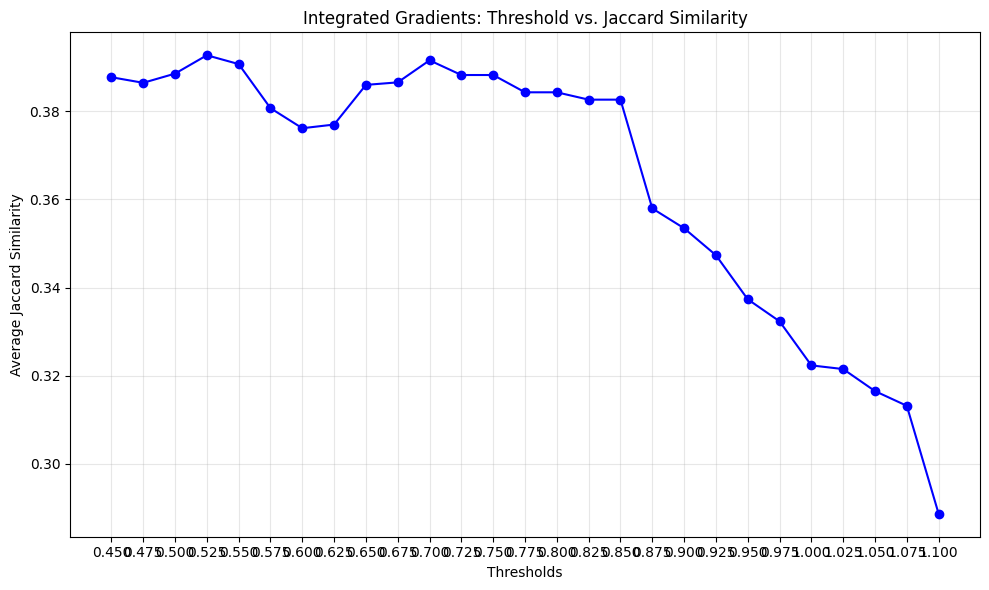

In [ ]:
from captum.attr import IntegratedGradients
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def get_word_importance_integrated_gradients(text, model, tokenizer, label_id=None, threshold=0.1):
    model.eval() # Use the passed model parameter

    # Tokenize with fast tokenizer (supports offsets)
    encoded = tokenizer(text,
                        return_tensors='pt',
                        truncation=True,
                        max_length=64,
                        return_offsets_mapping=True).to(device)
    input_ids = encoded['input_ids']
    attention_mask = encoded['attention_mask']

    # Get predicted label
    if label_id is None:
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            label_id = torch.argmax(outputs.logits, dim=1).item()

    # Forward function for attribution
    def forward_func(input_embeds):
        return model(inputs_embeds=input_embeds, attention_mask=attention_mask).logits[:, label_id]

    # Compute embeddings
    embedding_layer = model.get_input_embeddings()
    input_embeds = embedding_layer(input_ids)

    # Compute Integrated Gradients
    ig = IntegratedGradients(forward_func)
    attributions, _ = ig.attribute(inputs=input_embeds,
                                  baselines=torch.zeros_like(input_embeds),
                                  return_convergence_delta=True)

    # Sum attributions across embedding dimensions
    token_importances = attributions.sum(dim=-1).squeeze(0)
    token_ids = input_ids[0].cpu().tolist()
    tokens = tokenizer.convert_ids_to_tokens(token_ids)

    # Filter tokens by threshold
    important_tokens = []
    for i, (token, score) in enumerate(zip(tokens, token_importances)):
        # Apply absolute value to the score for thresholding,
        # as importance can be positive or negative.
        # This aligns with how Integrated Gradients measures influence.
        if token not in ['[CLS]', '[SEP]', '[PAD]'] and abs(score) >= threshold:
            # You might want to store the token score along with the token
            # if you need to order by importance later, but the current
            # function only returns tokens.
             important_tokens.append(token)


    return important_tokens


def evaluate_important_words_ig(model, tokenizer, df_sample, threshold=0.1):
    """Evaluate important words via Integrated Gradients vs selected_text."""
    results = []
    df_sample = df_sample[df_sample['sentiment'] != 'neutral']

    for _, row in df_sample.iterrows():
        text = row['text']
        selected_text = row['selected_text']

        # Get important words
        pred_tokens = set(get_word_importance_integrated_gradients(
            text, model, tokenizer, threshold=threshold # Pass the single threshold value here
        ))

        # Tokenize ground truth (using same tokenizer)
        true_tokens = set(tokenizer.tokenize(selected_text))

        # Compute Jaccard
        jaccard = len(pred_tokens & true_tokens) / len(pred_tokens | true_tokens) if pred_tokens or true_tokens else 0
        results.append(jaccard)

    return np.mean(results)

# Initialize FAST tokenizer (crucial fix)
from transformers import BertTokenizerFast, AutoTokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')  # For BERT
# tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=True)  # For BERTweet

# Run evaluation
non_neutral_test = test[test['sentiment'] != 'neutral'].sample(100, random_state=42)

thresholds = np.arange(0.45, 1.1, 0.025)  # Define thresholds as before
jaccard_scores = []

for n in thresholds:
    # Pass the current threshold value 'n' to the function's 'threshold' parameter
    score = evaluate_important_words_ig(model_bert, tokenizer, non_neutral_test, threshold=n)
    jaccard_scores.append(score)
    print(f"Threshold: {n:.2f} | Jaccard: {score:.3f}") # Print threshold value for clarity

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(thresholds, jaccard_scores, marker='o', linestyle='-', color='b')
plt.title("Integrated Gradients: Threshold vs. Jaccard Similarity")
plt.xlabel("Thresholds")
plt.ylabel("Average Jaccard Similarity")
plt.xticks(thresholds) # Use the 'thresholds' array for x-axis ticks
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("thres_vs_jaccard_ig.png", dpi=300)
plt.show()